In [1]:
from IPython.display import Image

### 학습기법들   
   
1. 최적화 방법 Optimization   (momentum, learning rate decay)   | local minimum, saddle point, plateau 해결, 학습 속도 향상
   
   
2. 가중치 초기화 방법 Weight Initialize : 가중치 감소 Weight Decay        | 기울기 소실 해결, 표현력 높임, 오버피팅 억제, 학습 속도 향상     
   
   
3. 배치 정규화 Batch Normalization   | 학습 속도 향상, 가중치 초기화 불필요, 오버피팅 억제
   
   
4. Regularization : = 가중치 감소 Weight Decay     | 오버피팅 억제,    
   
   
5. 드롭아웃 Dropout   | 오버피팅 억제,   
   
   
6. 적절한 하이퍼파라미터 값 찾기   
   
   
7. 하이퍼파라미터 최적화

# 1. Optimization


## 확률적 경사 하강법(SGD)

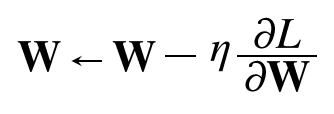

In [2]:
Image("1.png")

SGD는 기울어진 방향으로 일정거리만 가겠다는 단순한 방법

In [4]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):    # update 메서드는 SGD과정에서 반복해서 불린다
        for key in params.keys():
            params[key] -= self.lr * grads[key] # params, grads는 딕셔너리 변수다 

이렇게 최적화를 담당하는 클래스를 분리해 구현하면 기능을 모듈화하기 좋다.   
옵티마이저마다 update 메서드를 공통으로 갖게 하면   
필요한 옵티마이저의 인스턴스만 만들어 update메서드를 호출하면   
해당 옵티마이저를 편하게 골라 쓸 수 있다

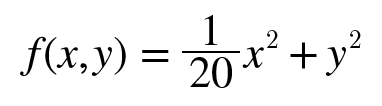

In [5]:
Image("2.png")

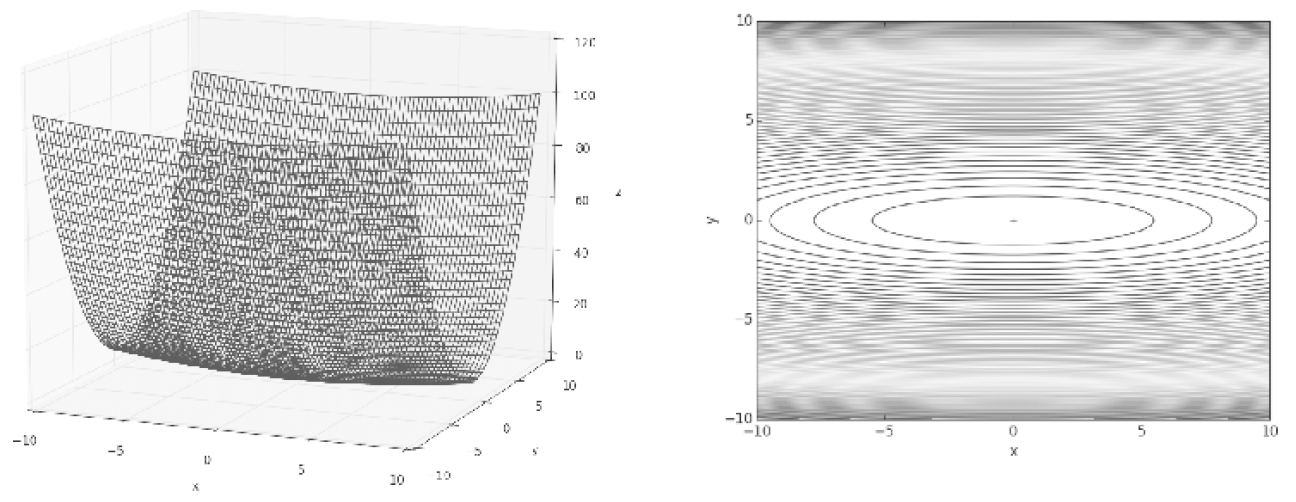

In [6]:
Image("3.png")

남북 방향으로는 로스의 변화량이 급격하고,  동서  방향으로는 로스의 변화량이 완만한 경우    
(특성들의 스케일이 매우 다르면 비용함수는 길쭉한 타원형의 그릇 모양이 될 수 있다-파라미터가 두개일 때)   
   
    
경사하강법을 사용할 때는 반드시 모든 특성이 같은 스케일을 갖도록 만들어야 한다   
예컨대 데이터의 각 특성에서 평균을 빼고 표준편차로 나눠 평균을 0으로 분산은 1로 만드는 식으로   

### 위와 같은 (비등방성)함수의 기울기를 그려보면 아래와 같다.   
글로벌미니멈은 좌표 (0,0)이지만   
대부분의 기울기는 (0,0)을 가리키지 않게 된다.

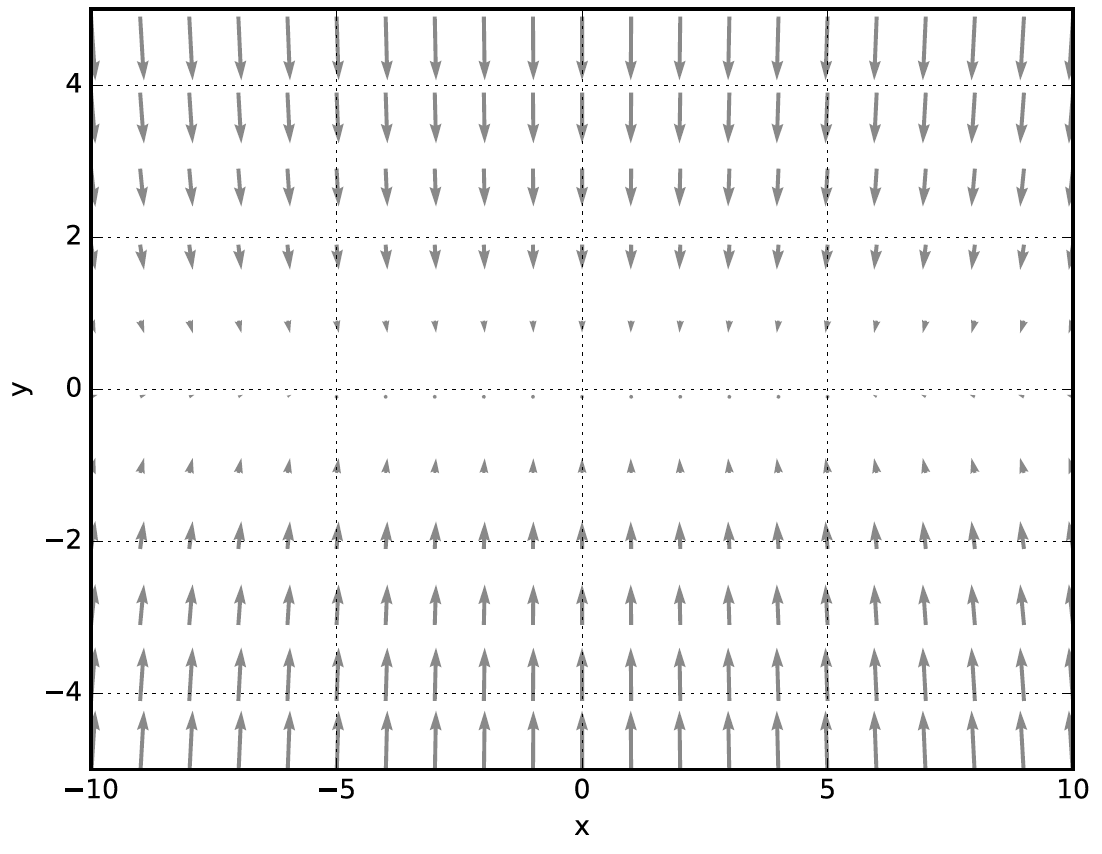

In [7]:
Image("4.png")

이런 공간에 SGD를 쓰면 지그재그 패턴을 그린다 : 탐색 경로가 비효율적이다.    
    지그재그로 탐색하는 근본원인은 기울어진 방향이 본래의 최솟값과 다른 방향을 가리켜서다.

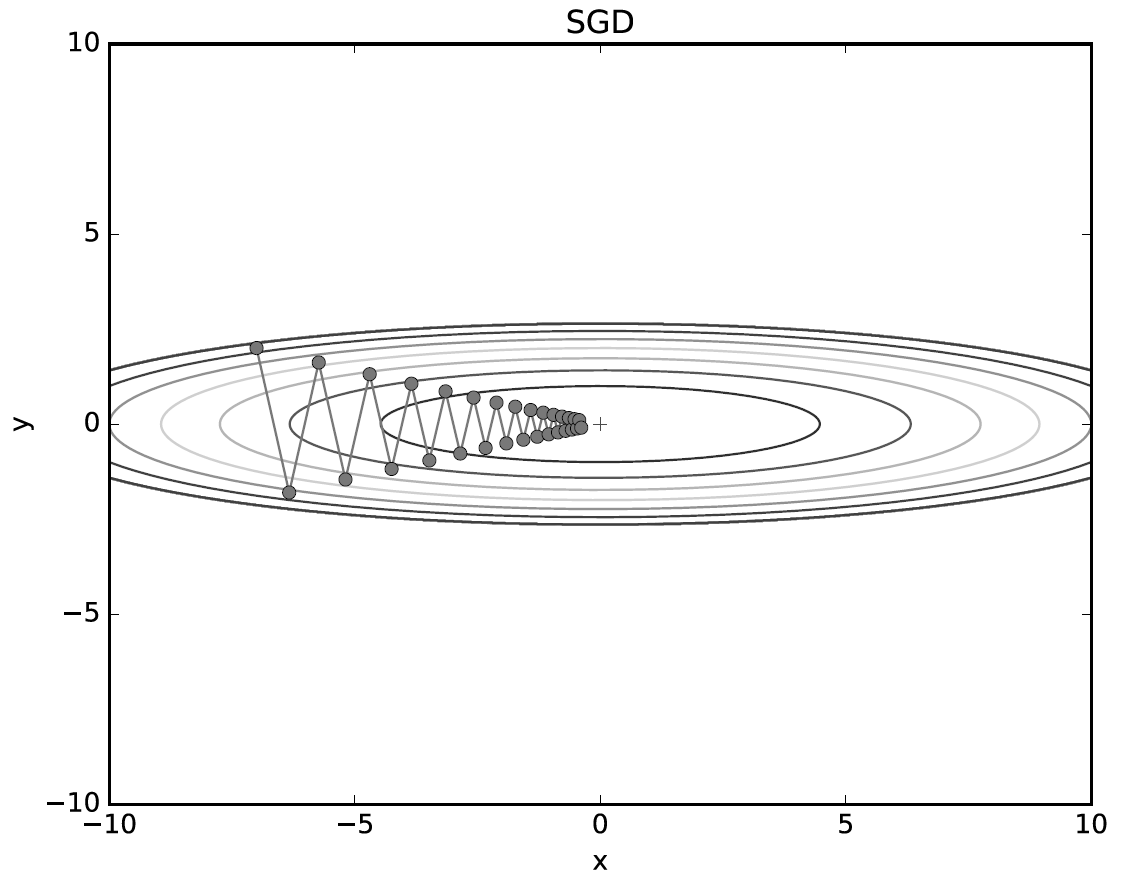

In [13]:
Image("5.png")

## 모멘텀

미시건 버전   

v = 0   
v = rho * v + dw(기울기)   
w = w - a * v   
   
w = w - (dw + a * rho * v)

밑시딥 버전   

v = 0   
v = rho * v - a * dw(기울기)   
w = w + v
   
w = w - (a * dw + rho * v)

In [3]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum  # rho 
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

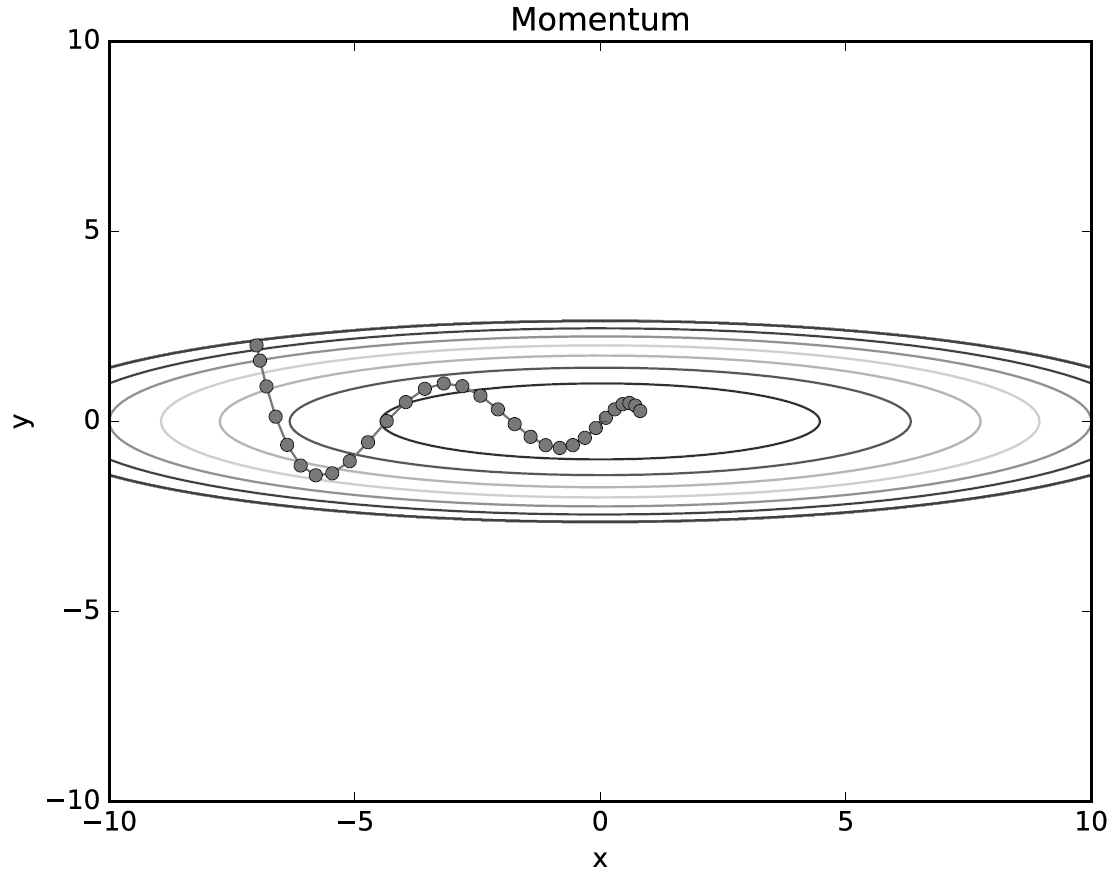

In [14]:
Image("6.png")

모멘텀은 SGD와 비교하면 지그재그정도가 덜하다   
v = rho * v - a * dw(기울기)     
기울기가 완만한 데선 v값이 커지고, 기울기가 급한 데선 v값이 작아진다.    
   
   
w = w + v                       
따라서 기울기가 완만한데선 더 쭉쭉 치고나가게 된다

## AdaGrad

learning rate decay   
학습률을 서서히 낮추는 가장 간단한 방법은 학습률을 일괄적으로 낮추는 것.   
   
      
         
         
AdaGrad는 학습률 감소가 매개변수의 원소마다 다르게 적용된다    
가중치중 크게 갱신된 가중치는 학습률이 낮아지게 된다.     

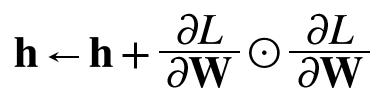

In [20]:
Image("7.png")

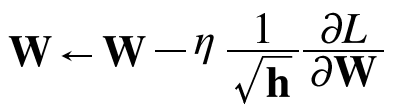

In [21]:
Image("8.png")

AdaGrad는 과거의 기울기를 아다마르 곲하여 계속 더해간다.   
따라서 학습이 아주 길어지면 어느 순간 갱신량이 0이 되어 전혀 갱신이 되지 않게 된다.   
   
   이를 해결하기 위한 기법이 RMSProp이다.   
   RMSProp은 과거의 모든 기울기를 균일하게 더해가지 않고   
   먼 과거의 기울기는 서서히 잊고   
   새로운 기울기 정보를 크게 반영한다.   
   
     
이를 지수 이동 평균 Exponential Moving Average EMA 라고 한다.   
과거 기울기의 반영규모를 기하급수적으로 감소시킨다

In [5]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.item():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

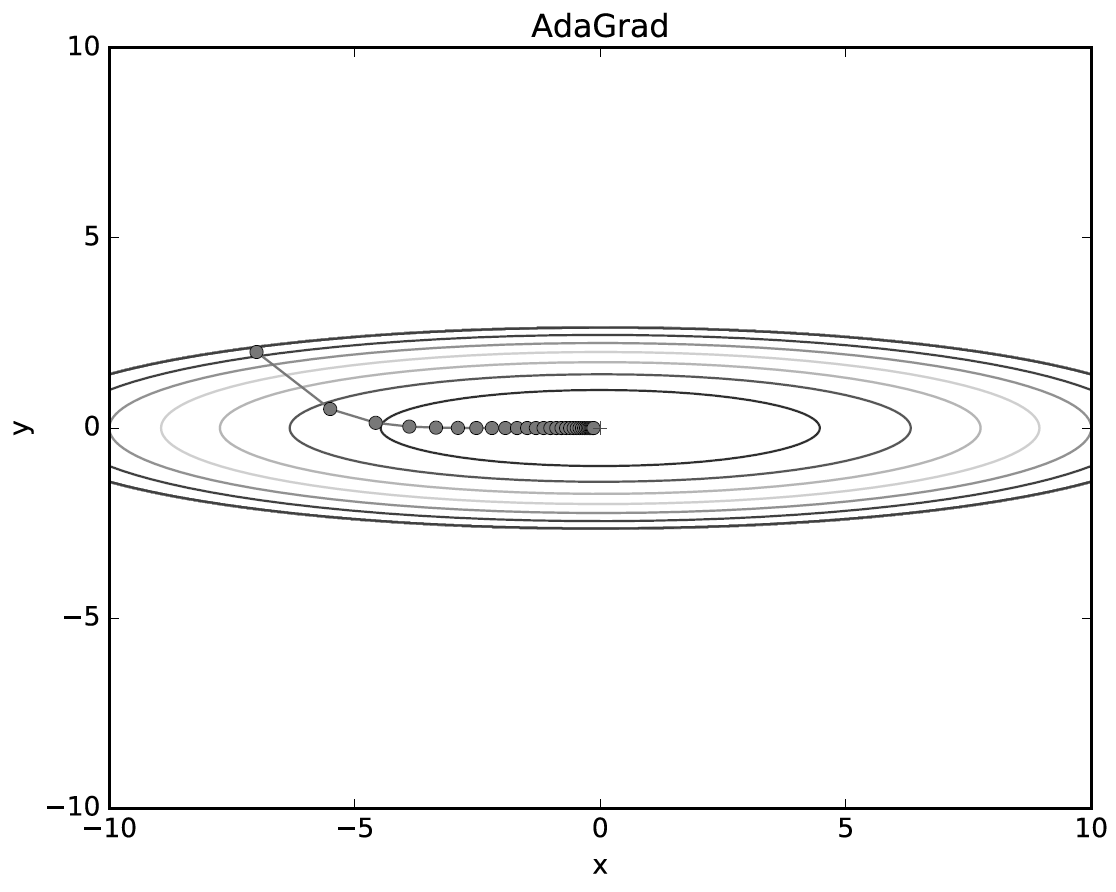

In [22]:
Image("9.png")

기울기가 급한 면에서는 처음엔 크게 갱신되지만   
그 큰 갱신정도에 비례해 갱신정도가 다시 큰 폭으로 작아지도록 조정되어   
y축방향으로 갱신강도는 빠르게 약해지고   
지그재그 패턴이 줄어들게 된다

# SGD, 모멘텀, AdaGrad, Adam의 학습 패턴 비교


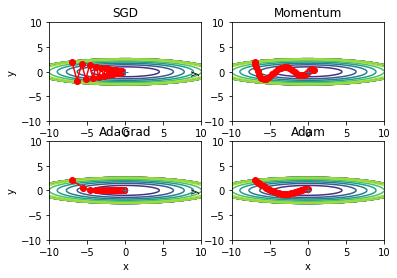

In [24]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

# MNIST 데이터셋 SGD, 모멘텀, AdaGrad, Adam의 학습 속도 비교

===========iteration:0===========
SGD:2.373428139709178
Momentum:2.395738325499509
AdaGrad:2.07828275870512
Adam:2.1630677324491807
===========iteration:100===========
SGD:1.4744592871580515
Momentum:0.22597361598562288
AdaGrad:0.06734661954338697
Adam:0.1264986339026471
===========iteration:200===========
SGD:0.836128786500608
Momentum:0.2923003614691698
AdaGrad:0.13722493205805658
Adam:0.19677376224244142
===========iteration:300===========
SGD:0.6362031106120313
Momentum:0.30073731580457885
AdaGrad:0.13772978576335257
Adam:0.22052113972024162
===========iteration:400===========
SGD:0.3245648880548122
Momentum:0.11390399041741556
AdaGrad:0.050500582824659704
Adam:0.0942487584111672
===========iteration:500===========
SGD:0.4308850780299295
Momentum:0.16582132826496143
AdaGrad:0.07103455527969746
Adam:0.08549244367132922
===========iteration:600===========
SGD:0.291531484516843
Momentum:0.08776655393047932
AdaGrad:0.04478474897536767
Adam:0.09751247209278571
===========iteration:700==

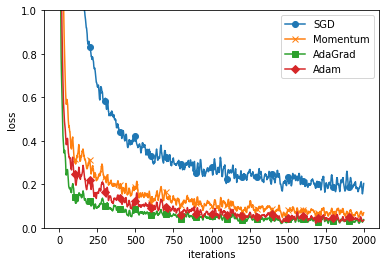

In [25]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

# 2. 가중치 초기화 방법

가중치 감소 Weight Decay : 가중치의 값이 작아지도록 학습하는 방법  
    가중치 값을 작게 하면 오버피팅이 일어나지 않게 된다 ?????????????????????????????????

가중치를 작게 만들고 싶으면 가중치 초기값을 최대한 작은 값에서 시작하게 할 수 있다.

가중치 초기값을 모두 0으로 하면 안 된다(가중치들을 균일한 값으로 설정해선 안 된다)   
순전파시 입력층 가중치가 0이면 두번째 층 뉴런이 모두 같은 값이 전달 된다   
그러면 역전파시 두 번째 층의 가중치가 모두 똑같이 갱신되게 된다 (곱셉 노드 역전파 참고)   
가중치 초기값을 균일한 값으로 설정하면 결과적으로 가중치를 여러 개 갖는 의미가 사라지게 된다.   
따라서 초기값은 무작위로 설정해야 한다


## 활성화 함수의 출력값의 분포를 분석하면 (은닉층의 활성화값 분포) 중요한 정보를 얻을 수 있다 


### 활성화 함수로 시그모이드 함수를 사용하는 5층 신경망에 무작위로 생성한 입력 데이터를 흘리며 
### 각 층의 활성화값 분포를 히스토그램으로 그려봅니다.

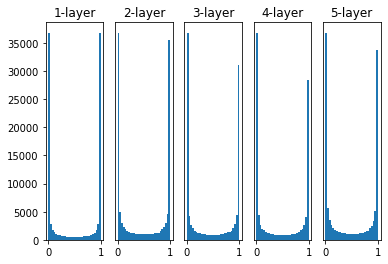

In [28]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！    
    # 분포된 정도 (표준편차)를 바꿔가며 활성화값들의 분포가 어덯게 변화하는지 관찰하는게 이 실험의 목적
    
    w = np.random.randn(node_num, node_num) * 1                # 표준편차가 1인 정규분포
    # w = np.random.randn(node_num, node_num) * 0.01              # 표준편차가 0.01인 정규분포
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)  # 표준편차가 0.1인 정규분포 
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)  # 표준편차가 √2 / 10인 정규분포 (약 0.141...)
    a = np.dot(x, w)
    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)
    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

# 표준편차가 1 일 때는 활성화 값들이 0과 1에 치우쳐 분포된다. 

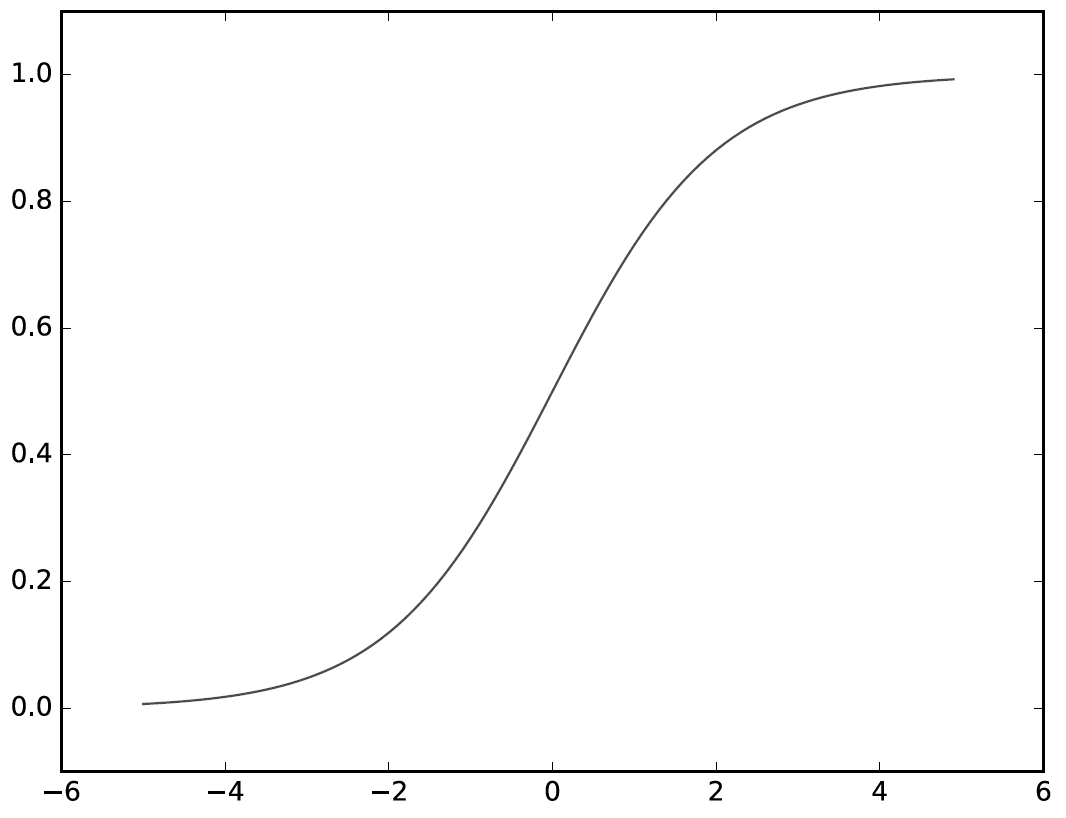

In [29]:
Image("10.png")

활성화 출력값이 0과 1에 치우쳐 분포되면, 역전파의 기울기가 작아져, 기울기 소실이 일어날 수 있다.   
이 문제는 층이 깊어지면 더 심해진다

# 표준편차를 0.01로 한 정규분포의 경우 활성화 값의 분포

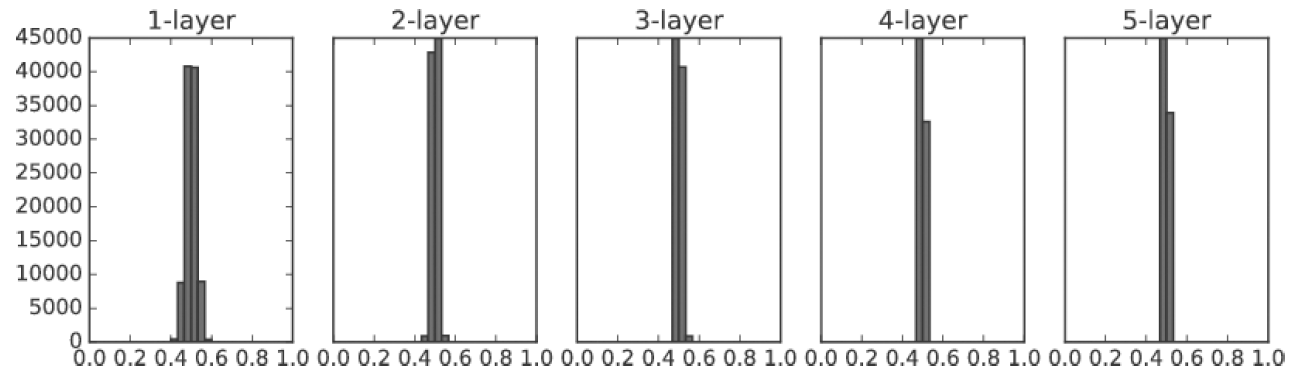

In [30]:
Image("11.png")

활성화 값이 0.5 부근에 집중된다.   
기울기 소실문제로부터는 자유로워졌지만 여전히 활성화 값들이 특정 범위에 치우쳐져 있으므로 (균일한 값으로 설정되어버리므로)   
### 표현력이 제한되는 문제가 있다. (뉴런을 여러 개 둔 의미가 없다) 다수의 뉴런이 거의 같은 값을 출력하고 있으므로

# 즉 활성화 값들이 치우쳐 있으면   
1. 기울기 소실   
2. 표현력 제한   
이라는 문제에 빠지게 된다

## Xavier 초기값  : sigmoid, tanh 에서 사용

- 이 초기값의 목적: 각 층의 활성화값들을 광범위하게 분포시키자 
   
- 방법: 앞 계층의 노드가 n개면, 표준편차가 1/√n 인 분포를 쓴다   
앞 층에 노드가 많을수록 대상 노드의 초기값으로 설정하는 가중치가 좁게 퍼짐   

In [31]:
 w = np.random.randn(node_num, node_num) / np.sqrt(node_num)

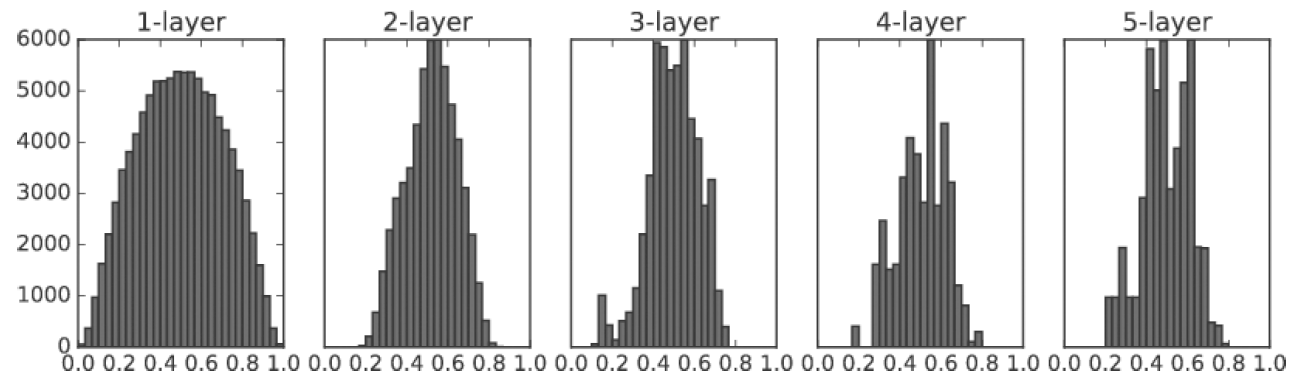

In [32]:
Image("12.png")

층이 깊어질수록 (형태가 다소 일그러지지만) 확실히 앞에서 본 방법보다 더 넓게 분포!   
   
   
그래도 층이 깊어지면서 치우침이 커지고 결국 기울시 소실 문제 발생 가능성이 있다 (시그모이드의 경우)

sigmoid 대신 tanh를 쓰면 깊은 층에서도 일그러지지 않고 종모양으로 분포된다   
   
   
sigmoid는 0, 0.5에서 대칭인 S곡선이지만   
tanh는 원점에서 대칭인 S 곡선이어서.    
   
   
활성화 함수용으로는 원점에서 대칭인 함수가 바람직하다

# He 초기값 : Relu 에서 사용   
앞 계층의 노드가 n개일 때, 표준편차가 루트 2/n 인 정규분포를 사용한다    
Relu는 음의 영역은 모두 0이기 때문에   
활성화 값을 더 넓게 분포시키기 위해 자비에르 초기값의 공식에 2배를 해준 거라고 볼수 있다

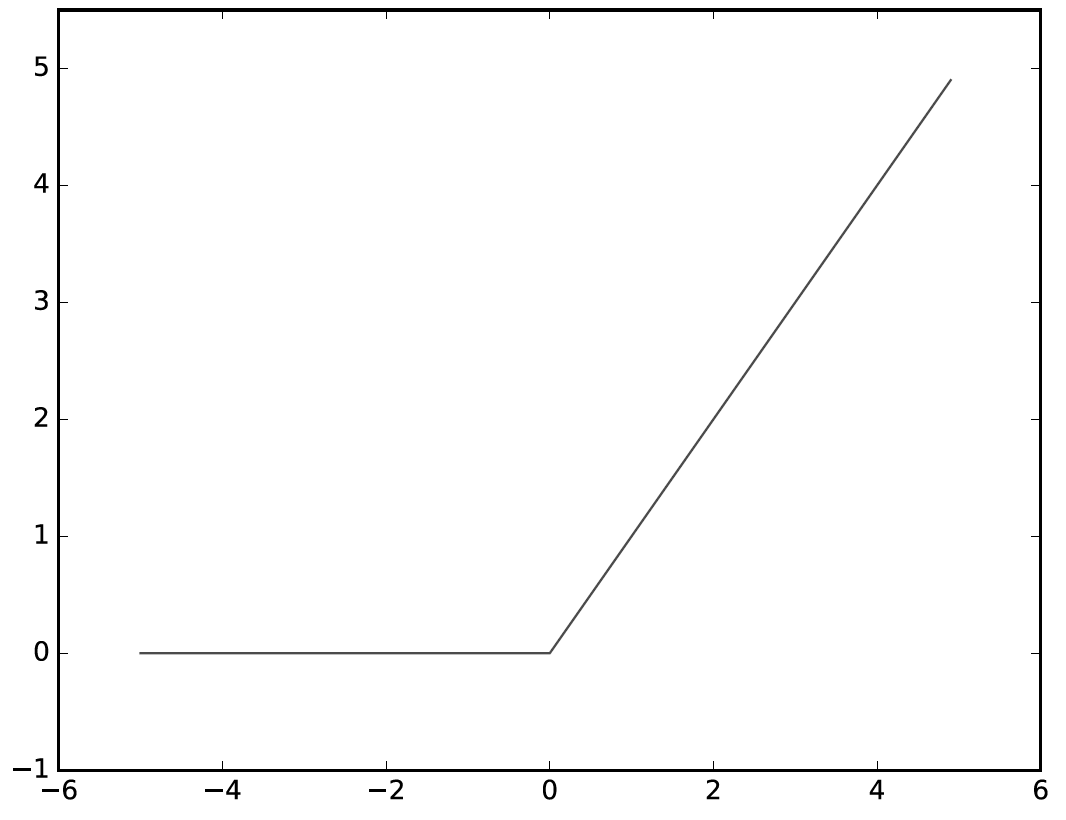

In [36]:
Image("13.png")

### Relu를 사용한 경우의 가중치 초기값에 따른 활성화값 분포 변화

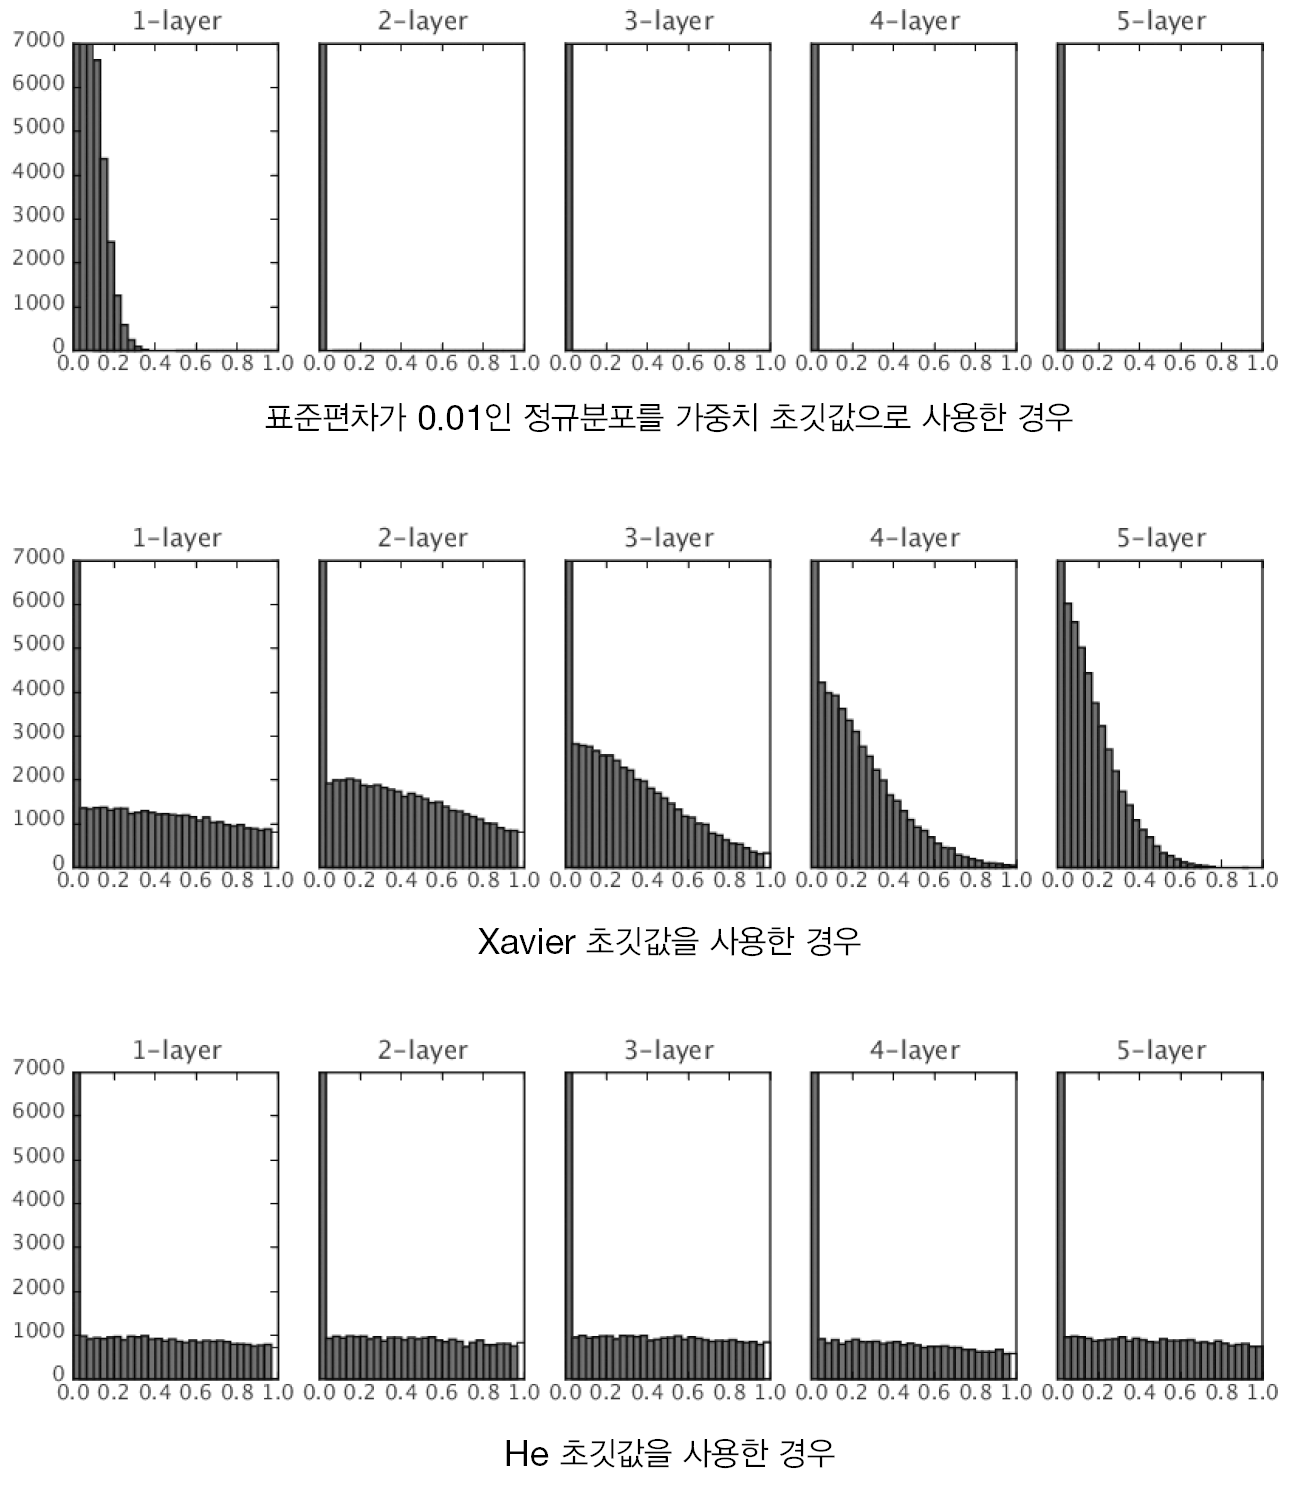

In [37]:
Image("14.png")

Relu에서 표준편차 0.01인 정규분포를 가중치 초기값으로 줬을 때 활성화값이 너무 작은값(0근처에 밀집한 값)으로 치우쳐지고    
Relu에서 자비에르를 초기값으로 써도 층이 깊어질수록 작은값으로 치우쳐져 기울기 소실 문제가 일어날 수 있다.   
He를 쓰면 모든층에서 활성화값이 균일하게 분포 된다. → 역전파 때도 적절한 값이 나옴

## MNIST 데이터셋으로 본 가중치 초깃값 비교
### 가중치 초깃값(std=0.01, He, Xavier)에 따른 학습 속도를 비교합니다.

===========iteration:0===========
std=0.01:2.30252796236797
Xavier:2.2951558174128595
He:2.334766148786354
===========iteration:100===========
std=0.01:2.3021191779623367
Xavier:2.2465142642411697
He:1.6143151992029667
===========iteration:200===========
std=0.01:2.3041048007986635
Xavier:2.103535761323959
He:0.9080015216856145
===========iteration:300===========
std=0.01:2.3022623354990106
Xavier:1.738353475755353
He:0.47459229571750716
===========iteration:400===========
std=0.01:2.3034005876279533
Xavier:1.2130478680491443
He:0.3967081797245264
===========iteration:500===========
std=0.01:2.303353918215302
Xavier:0.8379993718986146
He:0.3840124874053942
===========iteration:600===========
std=0.01:2.306431260257403
Xavier:0.8305082791981517
He:0.3946193319255964
===========iteration:700===========
std=0.01:2.298350281312117
Xavier:0.4156029953034881
He:0.17841399313617406
===========iteration:800===========
std=0.01:2.3008757756924867
Xavier:0.542232020837766
He:0.33883658250400817


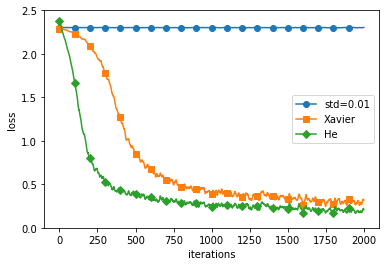

In [40]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

# 3. 배치 정규화


가중치 초기값을 적절히 설정해 각 층의 활성화값 분포가 고르게 퍼지게 하는 게 아니라   
각 층에 활성화값을 고르게 퍼뜨리도록 하는 별도의 층을 삽입하는 것   
이걸 함으로써 기대할 수 있는 효과의 원리가 뭔가?????????????????????????????????????????????

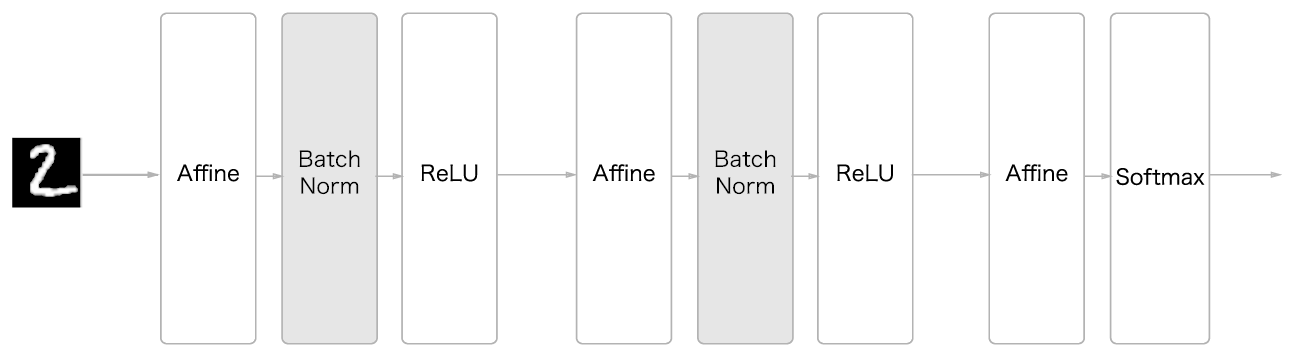

In [42]:
Image("15.png")

### 장점   
1. 학습 속도 빨라짐   
2. 초기값 설정 필요성 사라짐   
3. 오버피팅 억제

### BN은 학습시 미니배치를 단위로 정규화를 한다 : 데이터 분포가 평균이 0, 분산이 1이 되도록

미니배치 B = {x1, x2, x3, .... xm} 이라는 m 개의 입력 데이터 xi 의 집합에 대해 평균과 분산을 구한다.   
   
   
그리고 입력 데이터 xi 를 평균 0, 분산 1인 데이터 xi^ 으로 변환한다.   (적절한 분포가 되게 정규화 한다)   
   
   
(엡실론은 0으로 나누는 사태 예방)

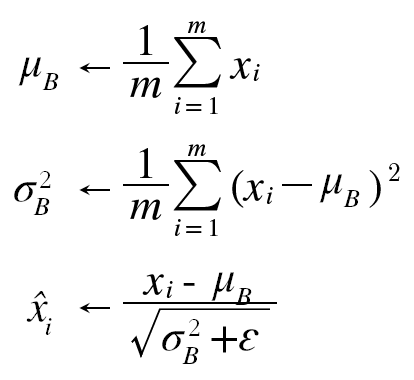

In [44]:
Image("16.png")

### 이 처리를 하는 층을 활성화 함수의 앞이나 뒤에 삽입하는 게 배치 정규화다

이렇게 하면 데이터 분포가 덜 치우치게 할 수 있다.

### 또 배치 정규화 계층마다   
이 정규화된 데이터들에 대해 고유한 확대 (scale)과  이동 (shift) 변환을 수행한다

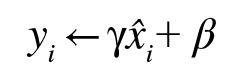

In [45]:
Image("17.png")

스케일을 하는 감마는 처음에 1   
시프트를 하는 베타는 처음에 0 부터 시작해   
학습이 진행 되면서 적합한 값으로 조정해 간다

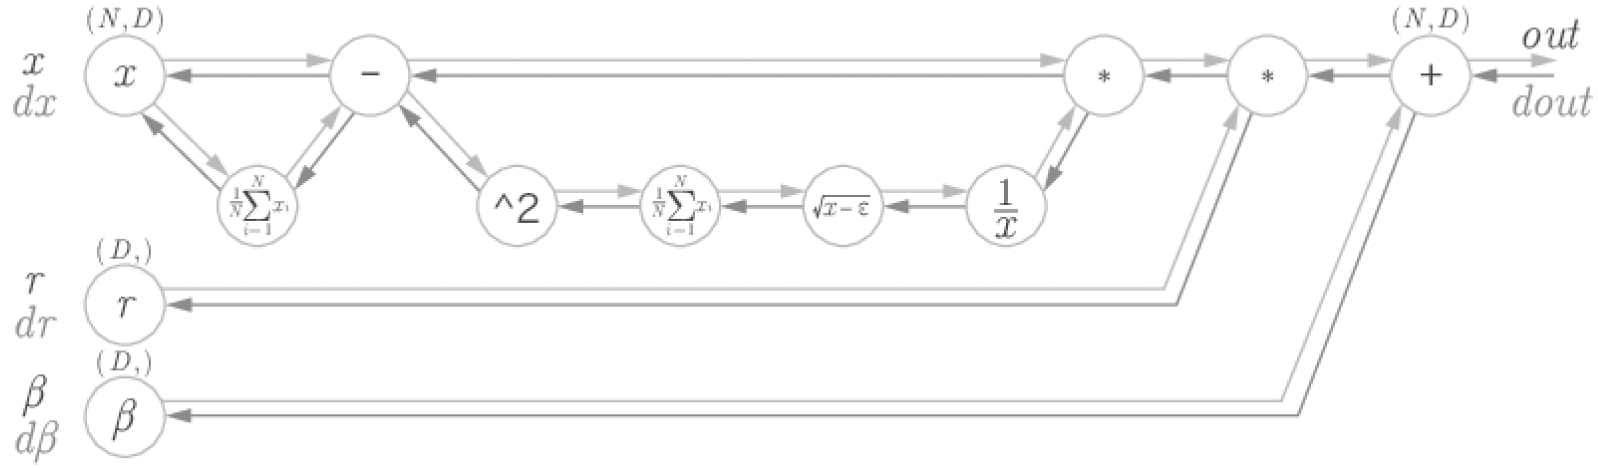

In [47]:
Image("18.png")

###  배치 정규화 효과 (Mnist 학습)

============== 1/16 ==============
epoch:0 | 0.117 - 0.114


..\common\functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)


epoch:1 | 0.097 - 0.122
epoch:2 | 0.097 - 0.117
epoch:3 | 0.097 - 0.127
epoch:4 | 0.097 - 0.143
epoch:5 | 0.097 - 0.16
epoch:6 | 0.097 - 0.19
epoch:7 | 0.097 - 0.218
epoch:8 | 0.097 - 0.248
epoch:9 | 0.097 - 0.268
epoch:10 | 0.097 - 0.294
epoch:11 | 0.097 - 0.313
epoch:12 | 0.097 - 0.332
epoch:13 | 0.097 - 0.334
epoch:14 | 0.097 - 0.351
epoch:15 | 0.097 - 0.365
epoch:16 | 0.097 - 0.386
epoch:17 | 0.097 - 0.399
epoch:18 | 0.097 - 0.412


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.433
============== 2/16 ==============
epoch:0 | 0.099 - 0.076


..\common\multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
..\common\multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.097 - 0.1
epoch:2 | 0.097 - 0.112
epoch:3 | 0.097 - 0.135
epoch:4 | 0.097 - 0.16
epoch:5 | 0.097 - 0.184
epoch:6 | 0.097 - 0.218
epoch:7 | 0.097 - 0.247
epoch:8 | 0.097 - 0.278
epoch:9 | 0.097 - 0.304
epoch:10 | 0.097 - 0.321
epoch:11 | 0.097 - 0.342
epoch:12 | 0.097 - 0.362
epoch:13 | 0.097 - 0.387
epoch:14 | 0.097 - 0.415
epoch:15 | 0.097 - 0.429
epoch:16 | 0.097 - 0.443
epoch:17 | 0.097 - 0.459
epoch:18 | 0.097 - 0.475


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.502
============== 3/16 ==============
epoch:0 | 0.108 - 0.106
epoch:1 | 0.339 - 0.119
epoch:2 | 0.541 - 0.163
epoch:3 | 0.614 - 0.206
epoch:4 | 0.707 - 0.25
epoch:5 | 0.74 - 0.277
epoch:6 | 0.799 - 0.308
epoch:7 | 0.83 - 0.344
epoch:8 | 0.865 - 0.367
epoch:9 | 0.894 - 0.415
epoch:10 | 0.913 - 0.444
epoch:11 | 0.93 - 0.461
epoch:12 | 0.947 - 0.494
epoch:13 | 0.954 - 0.517
epoch:14 | 0.97 - 0.54
epoch:15 | 0.978 - 0.567
epoch:16 | 0.982 - 0.587
epoch:17 | 0.982 - 0.6
epoch:18 | 0.989 - 0.606


No handles with labels found to put in legend.


epoch:19 | 0.992 - 0.629
============== 4/16 ==============
epoch:0 | 0.127 - 0.074
epoch:1 | 0.298 - 0.082
epoch:2 | 0.414 - 0.21
epoch:3 | 0.501 - 0.306
epoch:4 | 0.548 - 0.394
epoch:5 | 0.626 - 0.452
epoch:6 | 0.646 - 0.518
epoch:7 | 0.675 - 0.568
epoch:8 | 0.715 - 0.607
epoch:9 | 0.743 - 0.633
epoch:10 | 0.762 - 0.65
epoch:11 | 0.77 - 0.67
epoch:12 | 0.789 - 0.695
epoch:13 | 0.794 - 0.718
epoch:14 | 0.812 - 0.741
epoch:15 | 0.83 - 0.748
epoch:16 | 0.834 - 0.768
epoch:17 | 0.835 - 0.779
epoch:18 | 0.849 - 0.795


No handles with labels found to put in legend.


epoch:19 | 0.862 - 0.805
============== 5/16 ==============
epoch:0 | 0.126 - 0.118
epoch:1 | 0.128 - 0.169
epoch:2 | 0.134 - 0.291
epoch:3 | 0.135 - 0.399
epoch:4 | 0.138 - 0.471
epoch:5 | 0.141 - 0.566
epoch:6 | 0.155 - 0.61
epoch:7 | 0.15 - 0.661
epoch:8 | 0.169 - 0.696
epoch:9 | 0.173 - 0.727
epoch:10 | 0.183 - 0.751
epoch:11 | 0.198 - 0.778
epoch:12 | 0.202 - 0.796
epoch:13 | 0.214 - 0.823
epoch:14 | 0.232 - 0.824
epoch:15 | 0.241 - 0.835
epoch:16 | 0.252 - 0.845
epoch:17 | 0.272 - 0.86
epoch:18 | 0.287 - 0.87


No handles with labels found to put in legend.


epoch:19 | 0.307 - 0.883
============== 6/16 ==============
epoch:0 | 0.06 - 0.123
epoch:1 | 0.114 - 0.296
epoch:2 | 0.117 - 0.478
epoch:3 | 0.117 - 0.597
epoch:4 | 0.117 - 0.686
epoch:5 | 0.117 - 0.753
epoch:6 | 0.117 - 0.796
epoch:7 | 0.117 - 0.814
epoch:8 | 0.117 - 0.844
epoch:9 | 0.117 - 0.867
epoch:10 | 0.117 - 0.883
epoch:11 | 0.117 - 0.892
epoch:12 | 0.117 - 0.906
epoch:13 | 0.117 - 0.919
epoch:14 | 0.117 - 0.928
epoch:15 | 0.117 - 0.929
epoch:16 | 0.117 - 0.935
epoch:17 | 0.117 - 0.942
epoch:18 | 0.117 - 0.948


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.95
============== 7/16 ==============
epoch:0 | 0.099 - 0.081
epoch:1 | 0.116 - 0.23
epoch:2 | 0.116 - 0.539
epoch:3 | 0.116 - 0.7
epoch:4 | 0.116 - 0.746
epoch:5 | 0.116 - 0.801
epoch:6 | 0.116 - 0.834
epoch:7 | 0.116 - 0.869
epoch:8 | 0.116 - 0.883
epoch:9 | 0.116 - 0.9
epoch:10 | 0.116 - 0.92
epoch:11 | 0.116 - 0.935
epoch:12 | 0.116 - 0.944
epoch:13 | 0.116 - 0.951
epoch:14 | 0.116 - 0.957
epoch:15 | 0.116 - 0.961
epoch:16 | 0.116 - 0.97
epoch:17 | 0.116 - 0.977
epoch:18 | 0.117 - 0.977


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.985
============== 8/16 ==============
epoch:0 | 0.1 - 0.159
epoch:1 | 0.116 - 0.382
epoch:2 | 0.1 - 0.623
epoch:3 | 0.116 - 0.712
epoch:4 | 0.116 - 0.773
epoch:5 | 0.116 - 0.827
epoch:6 | 0.116 - 0.886
epoch:7 | 0.116 - 0.918
epoch:8 | 0.116 - 0.956
epoch:9 | 0.116 - 0.972
epoch:10 | 0.116 - 0.978
epoch:11 | 0.116 - 0.984
epoch:12 | 0.116 - 0.988
epoch:13 | 0.116 - 0.992
epoch:14 | 0.116 - 0.994
epoch:15 | 0.116 - 0.997
epoch:16 | 0.116 - 0.998
epoch:17 | 0.116 - 0.998
epoch:18 | 0.116 - 0.998


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.998
============== 9/16 ==============
epoch:0 | 0.116 - 0.13
epoch:1 | 0.117 - 0.526
epoch:2 | 0.117 - 0.729
epoch:3 | 0.117 - 0.861
epoch:4 | 0.117 - 0.926
epoch:5 | 0.117 - 0.953
epoch:6 | 0.117 - 0.976
epoch:7 | 0.117 - 0.985
epoch:8 | 0.117 - 0.986
epoch:9 | 0.117 - 0.992
epoch:10 | 0.117 - 0.996
epoch:11 | 0.117 - 0.997
epoch:12 | 0.117 - 0.997
epoch:13 | 0.117 - 0.997
epoch:14 | 0.117 - 0.997
epoch:15 | 0.117 - 0.998
epoch:16 | 0.117 - 0.999
epoch:17 | 0.117 - 0.999
epoch:18 | 0.117 - 1.0


No handles with labels found to put in legend.


epoch:19 | 0.117 - 1.0
============== 10/16 ==============
epoch:0 | 0.117 - 0.146
epoch:1 | 0.1 - 0.646
epoch:2 | 0.117 - 0.819
epoch:3 | 0.117 - 0.854
epoch:4 | 0.117 - 0.875
epoch:5 | 0.117 - 0.944
epoch:6 | 0.117 - 0.96
epoch:7 | 0.117 - 0.974
epoch:8 | 0.117 - 0.968
epoch:9 | 0.117 - 0.987
epoch:10 | 0.117 - 0.991
epoch:11 | 0.117 - 0.995
epoch:12 | 0.117 - 0.998
epoch:13 | 0.117 - 0.997
epoch:14 | 0.117 - 0.997
epoch:15 | 0.117 - 0.994
epoch:16 | 0.117 - 0.943
epoch:17 | 0.117 - 0.994
epoch:18 | 0.117 - 0.998


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.998
============== 11/16 ==============
epoch:0 | 0.092 - 0.215
epoch:1 | 0.105 - 0.624
epoch:2 | 0.116 - 0.699
epoch:3 | 0.116 - 0.812
epoch:4 | 0.116 - 0.847
epoch:5 | 0.117 - 0.861
epoch:6 | 0.117 - 0.838
epoch:7 | 0.117 - 0.872
epoch:8 | 0.117 - 0.863
epoch:9 | 0.117 - 0.883
epoch:10 | 0.117 - 0.885
epoch:11 | 0.117 - 0.887
epoch:12 | 0.117 - 0.891
epoch:13 | 0.117 - 0.893
epoch:14 | 0.117 - 0.891
epoch:15 | 0.117 - 0.894
epoch:16 | 0.117 - 0.894
epoch:17 | 0.117 - 0.891
epoch:18 | 0.117 - 0.895


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.923
============== 12/16 ==============
epoch:0 | 0.117 - 0.252
epoch:1 | 0.117 - 0.485
epoch:2 | 0.117 - 0.623
epoch:3 | 0.117 - 0.661
epoch:4 | 0.117 - 0.663
epoch:5 | 0.117 - 0.721
epoch:6 | 0.117 - 0.735
epoch:7 | 0.117 - 0.746
epoch:8 | 0.117 - 0.704
epoch:9 | 0.117 - 0.761
epoch:10 | 0.117 - 0.782
epoch:11 | 0.117 - 0.78
epoch:12 | 0.117 - 0.751
epoch:13 | 0.117 - 0.797
epoch:14 | 0.117 - 0.796
epoch:15 | 0.117 - 0.804
epoch:16 | 0.117 - 0.801
epoch:17 | 0.117 - 0.796
epoch:18 | 0.117 - 0.768


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.786
============== 13/16 ==============
epoch:0 | 0.099 - 0.183
epoch:1 | 0.116 - 0.515
epoch:2 | 0.116 - 0.588
epoch:3 | 0.116 - 0.664
epoch:4 | 0.117 - 0.677
epoch:5 | 0.116 - 0.684
epoch:6 | 0.117 - 0.651
epoch:7 | 0.117 - 0.685
epoch:8 | 0.117 - 0.714
epoch:9 | 0.117 - 0.797
epoch:10 | 0.117 - 0.8
epoch:11 | 0.117 - 0.802
epoch:12 | 0.117 - 0.789
epoch:13 | 0.117 - 0.808
epoch:14 | 0.117 - 0.799
epoch:15 | 0.117 - 0.807
epoch:16 | 0.117 - 0.4
epoch:17 | 0.117 - 0.805
epoch:18 | 0.117 - 0.797


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.813
============== 14/16 ==============
epoch:0 | 0.116 - 0.154
epoch:1 | 0.116 - 0.445
epoch:2 | 0.116 - 0.479
epoch:3 | 0.116 - 0.503
epoch:4 | 0.116 - 0.474
epoch:5 | 0.117 - 0.512
epoch:6 | 0.116 - 0.479
epoch:7 | 0.116 - 0.517
epoch:8 | 0.116 - 0.535
epoch:9 | 0.116 - 0.522
epoch:10 | 0.116 - 0.512
epoch:11 | 0.117 - 0.601
epoch:12 | 0.117 - 0.601
epoch:13 | 0.117 - 0.611
epoch:14 | 0.117 - 0.602
epoch:15 | 0.117 - 0.588
epoch:16 | 0.117 - 0.597
epoch:17 | 0.117 - 0.613
epoch:18 | 0.117 - 0.615


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.614
============== 15/16 ==============
epoch:0 | 0.097 - 0.097
epoch:1 | 0.117 - 0.372
epoch:2 | 0.117 - 0.413
epoch:3 | 0.117 - 0.471
epoch:4 | 0.117 - 0.489
epoch:5 | 0.117 - 0.498
epoch:6 | 0.117 - 0.509
epoch:7 | 0.117 - 0.48
epoch:8 | 0.117 - 0.501
epoch:9 | 0.117 - 0.51
epoch:10 | 0.117 - 0.515
epoch:11 | 0.117 - 0.515
epoch:12 | 0.117 - 0.526
epoch:13 | 0.117 - 0.516
epoch:14 | 0.117 - 0.522
epoch:15 | 0.117 - 0.529
epoch:16 | 0.117 - 0.519
epoch:17 | 0.117 - 0.527
epoch:18 | 0.117 - 0.531


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.533
============== 16/16 ==============
epoch:0 | 0.097 - 0.099
epoch:1 | 0.105 - 0.28
epoch:2 | 0.105 - 0.211
epoch:3 | 0.117 - 0.418
epoch:4 | 0.117 - 0.401
epoch:5 | 0.117 - 0.42
epoch:6 | 0.117 - 0.42
epoch:7 | 0.117 - 0.421
epoch:8 | 0.117 - 0.42
epoch:9 | 0.117 - 0.419
epoch:10 | 0.117 - 0.421
epoch:11 | 0.117 - 0.422
epoch:12 | 0.117 - 0.427
epoch:13 | 0.117 - 0.523
epoch:14 | 0.117 - 0.522
epoch:15 | 0.117 - 0.509
epoch:16 | 0.117 - 0.521
epoch:17 | 0.117 - 0.526
epoch:18 | 0.117 - 0.5
epoch:19 | 0.117 - 0.526


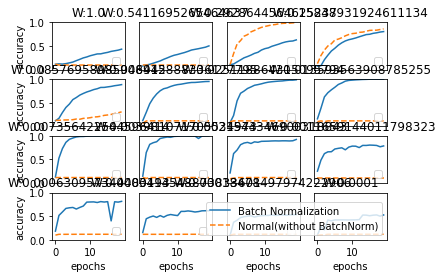

In [48]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

# 오버피팅


## **오버피팅이 일어나는 경우**   
### 1. 매개변수가 많고 표현력이 높은 모델   
### 2. 훈련 데이터가 적을 때

### 일부러 오버피팅을 일으키기 위해 MNIST 6만개 데이터 중 300개만 쓰고   
### 7층 네트워크로 만들어 모델 복잡성을 높여 실험   

epoch:0, train acc:0.08666666666666667, test acc:0.0737
epoch:1, train acc:0.11333333333333333, test acc:0.0824
epoch:2, train acc:0.14, test acc:0.0994
epoch:3, train acc:0.15333333333333332, test acc:0.116
epoch:4, train acc:0.17333333333333334, test acc:0.1263
epoch:5, train acc:0.18666666666666668, test acc:0.1343
epoch:6, train acc:0.19333333333333333, test acc:0.14
epoch:7, train acc:0.21333333333333335, test acc:0.1519
epoch:8, train acc:0.24, test acc:0.1614
epoch:9, train acc:0.27, test acc:0.1753
epoch:10, train acc:0.30333333333333334, test acc:0.1979
epoch:11, train acc:0.32666666666666666, test acc:0.22
epoch:12, train acc:0.3433333333333333, test acc:0.226
epoch:13, train acc:0.38, test acc:0.2525
epoch:14, train acc:0.38, test acc:0.2526
epoch:15, train acc:0.39666666666666667, test acc:0.2638
epoch:16, train acc:0.4166666666666667, test acc:0.2766
epoch:17, train acc:0.4666666666666667, test acc:0.3026
epoch:18, train acc:0.48333333333333334, test acc:0.3134
epoch:19, t

epoch:164, train acc:1.0, test acc:0.7523
epoch:165, train acc:1.0, test acc:0.7518
epoch:166, train acc:1.0, test acc:0.7523
epoch:167, train acc:1.0, test acc:0.7536
epoch:168, train acc:1.0, test acc:0.7539
epoch:169, train acc:1.0, test acc:0.7542
epoch:170, train acc:1.0, test acc:0.7537
epoch:171, train acc:1.0, test acc:0.7552
epoch:172, train acc:1.0, test acc:0.7528
epoch:173, train acc:1.0, test acc:0.7509
epoch:174, train acc:1.0, test acc:0.7502
epoch:175, train acc:1.0, test acc:0.7534
epoch:176, train acc:1.0, test acc:0.7528
epoch:177, train acc:1.0, test acc:0.7534
epoch:178, train acc:1.0, test acc:0.7527
epoch:179, train acc:1.0, test acc:0.7546
epoch:180, train acc:1.0, test acc:0.7548
epoch:181, train acc:1.0, test acc:0.7539
epoch:182, train acc:1.0, test acc:0.7533
epoch:183, train acc:1.0, test acc:0.7517
epoch:184, train acc:1.0, test acc:0.7529
epoch:185, train acc:1.0, test acc:0.7503
epoch:186, train acc:1.0, test acc:0.7495
epoch:187, train acc:1.0, test acc

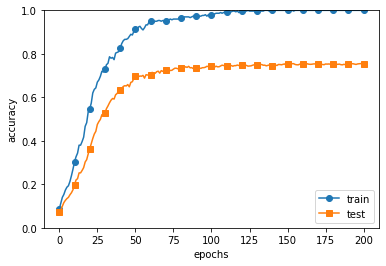

In [3]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
# weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]   # 300
batch_size = 100

train_loss_list = []
train_acc_list = []     # 에폭 단위의 정확도를 저장 
test_acc_list = []      # 에폭 단위의 정확도를 저장 

iter_per_epoch = max(train_size / batch_size, 1)  # 3
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:   # 3번 돌아야 1 에폭 
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# 4. Regularization

## 오버피팅은 가중치 매개변수의 값이 커서 발생하는 경우가 많다   
### 학습시 큰 가중치에 대해서는 그에 상응하는 큰 페널티를 부과해 오버피팅을 억제할 수 있다

L2 Norm을 손실함수에 더하면 가중치가 커지는 것을 억제할 수 있다.   
람다값을 크게할수록 큰 가중치에 대한 페널티가 커진다   
regularizer는 모든 가중치 각각의 손실함수(로스)에 규제항을 더한다.  
따라서 가중치의 기울기를 구하는 계산에서는 그동안의 오차역전파법에 따른 결과에 규제항을 미분한 값을 더한다.   
    >>>>>>>>>>이게 왜 가중치가 커지는 걸 억제시키지?    
    >>>>>>>>>>>>>>>>>>>> w크기를 loss에 더해서 이 최종로스를 가지고 기울기를 업데이트하므로 (W = W - grad) 가중치가 커지면   
    그때의 W의 크기가 규제항에 반영되어 업데이트할 기울기 값이 조절되는 거 같다

### 일부러 오버피팅을 일으킨 후 가중치 감소(weight_decay)의 효과를 관찰합니다.

epoch:0, train acc:0.11666666666666667, test acc:0.1039
epoch:1, train acc:0.13, test acc:0.1094
epoch:2, train acc:0.19333333333333333, test acc:0.1354
epoch:3, train acc:0.24, test acc:0.1634
epoch:4, train acc:0.2633333333333333, test acc:0.1776
epoch:5, train acc:0.26, test acc:0.181
epoch:6, train acc:0.2833333333333333, test acc:0.1917
epoch:7, train acc:0.27666666666666667, test acc:0.2051
epoch:8, train acc:0.31333333333333335, test acc:0.2264
epoch:9, train acc:0.33, test acc:0.2301
epoch:10, train acc:0.38333333333333336, test acc:0.2607
epoch:11, train acc:0.42, test acc:0.2825
epoch:12, train acc:0.49666666666666665, test acc:0.3155
epoch:13, train acc:0.4766666666666667, test acc:0.3174
epoch:14, train acc:0.5, test acc:0.3316
epoch:15, train acc:0.49666666666666665, test acc:0.3347
epoch:16, train acc:0.57, test acc:0.3768
epoch:17, train acc:0.5533333333333333, test acc:0.3855
epoch:18, train acc:0.6, test acc:0.4046
epoch:19, train acc:0.6233333333333333, test acc:0.434

epoch:163, train acc:0.9033333333333333, test acc:0.7215
epoch:164, train acc:0.9, test acc:0.7224
epoch:165, train acc:0.8933333333333333, test acc:0.7222
epoch:166, train acc:0.8933333333333333, test acc:0.7307
epoch:167, train acc:0.9133333333333333, test acc:0.7197
epoch:168, train acc:0.9033333333333333, test acc:0.7258
epoch:169, train acc:0.91, test acc:0.7219
epoch:170, train acc:0.9033333333333333, test acc:0.7247
epoch:171, train acc:0.9033333333333333, test acc:0.7211
epoch:172, train acc:0.8966666666666666, test acc:0.7217
epoch:173, train acc:0.9, test acc:0.715
epoch:174, train acc:0.89, test acc:0.7231
epoch:175, train acc:0.9066666666666666, test acc:0.7185
epoch:176, train acc:0.92, test acc:0.7206
epoch:177, train acc:0.8966666666666666, test acc:0.7218
epoch:178, train acc:0.9033333333333333, test acc:0.7275
epoch:179, train acc:0.9133333333333333, test acc:0.722
epoch:180, train acc:0.8966666666666666, test acc:0.723
epoch:181, train acc:0.9033333333333333, test acc

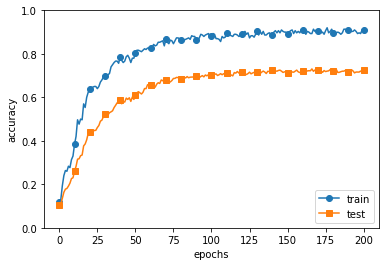

In [4]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 ======================= MultiLayerNet 클래스의 loss 메서드
#    def loss(self, x, t):
#         y = self.predict(x)

#         weight_decay = 0
#         for idx in range(1, self.hidden_layer_num + 2):
#             W = self.params['W' + str(idx)]
#             weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)  
                           # 모든 가중치 각각의 손실함수에 (1/2 * λ * W**2) 를 더한 게 아래 리턴 값이 되고
                           # 가중치의 기울기를 계산하는 과정에서는 아래 기울기를 구하는 grads = network.gradient(x_batch, t_batch) 코드에서   
                           # 그동안의 오차역전파법에 따른 결과에 λW를 계속 더해준다.  >>> 미시건 lec03 60 참고 
                           # >>>> (1/2 * λ * W**2)를 W에 대해 미분하면 (regularization term을 미분하면) λW가 된다. 
                    
#         return self.last_layer.forward(y, t) + weight_decay   # 순전파 마지막에 소프트맥스 크로스엔트로피 층 지나 구한 loss에 
#                                                               # weight_decay 를 더한 값을 최종 loss로 반환한다. 

# weight_decay_lambda = 0 weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]   # 300
batch_size = 100

train_loss_list = []
train_acc_list = []     # 에폭 단위의 정확도를 저장 
test_acc_list = []      # 에폭 단위의 정확도를 저장 

iter_per_epoch = max(train_size / batch_size, 1)  # 3
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:   # 3번 돌아야 1 에폭 
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [ ]:
# MultiLayerNet 클래스의 gradient 메서드 
# def gradient(self, x, t):

#         # forward
#         self.loss(x, t)

#         # backward
#         dout = 1
#         dout = self.last_layer.backward(dout)

#         layers = list(self.layers.values())
#         layers.reverse()
#         for layer in layers:
#             dout = layer.backward(dout)

#         # 결과 저장
#         grads = {}
#         for idx in range(1, self.hidden_layer_num+2):
#             grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
              # 그동안의 오차역전파법에 따른 결과에 (regularization term을 미분한) λW를 더해준다. 
#             grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

#         return grads


## 5. 드롭아웃

훈련 때는 데이터를 흘릴 때마다 삭제할 뉴런을 무작위로 선택   
   
   시험 때는 모든 뉴런에 신호를 전달   
      
      대신 각 뉴런의 출력에 훈련 때 삭제 안 한 비율을 곱하여 출력




### 드롭아웃 미적용

train loss:2.325888114833629
=== epoch:1, train acc:0.10666666666666667, test acc:0.1018 ===
train loss:2.3041519205857823
train loss:2.3533515678662154
train loss:2.318705990417258
=== epoch:2, train acc:0.12, test acc:0.1066 ===
train loss:2.3337612387696196
train loss:2.3031671012684
train loss:2.33286001467928
=== epoch:3, train acc:0.13333333333333333, test acc:0.1164 ===
train loss:2.2922572248825563
train loss:2.288639054260529
train loss:2.2587746787783853
=== epoch:4, train acc:0.13333333333333333, test acc:0.1279 ===
train loss:2.255159616538843
train loss:2.2775006494154484
train loss:2.2679067532318387
=== epoch:5, train acc:0.15333333333333332, test acc:0.1338 ===
train loss:2.21209542258322
train loss:2.1349963368277365
train loss:2.243079167640813
=== epoch:6, train acc:0.18, test acc:0.1439 ===
train loss:2.2011735946537456
train loss:2.256892445972007
train loss:2.189206349991297
=== epoch:7, train acc:0.21, test acc:0.1544 ===
train loss:2.167795658040586
train loss:2

=== epoch:56, train acc:0.88, test acc:0.6592 ===
train loss:0.6440214657308263
train loss:0.5010461942351427
train loss:0.6002149251817308
=== epoch:57, train acc:0.8766666666666667, test acc:0.6642 ===
train loss:0.4649077585550023
train loss:0.5248205043948393
train loss:0.44217225741079524
=== epoch:58, train acc:0.87, test acc:0.6646 ===
train loss:0.662364687100037
train loss:0.5245498500431808
train loss:0.4592099801059759
=== epoch:59, train acc:0.8866666666666667, test acc:0.6716 ===
train loss:0.4875465165158228
train loss:0.466627108590504
train loss:0.4336943326808745
=== epoch:60, train acc:0.8833333333333333, test acc:0.679 ===
train loss:0.5446679532194838
train loss:0.47880216156993916
train loss:0.4361050304095103
=== epoch:61, train acc:0.8833333333333333, test acc:0.668 ===
train loss:0.4414571357862391
train loss:0.37236649460448057
train loss:0.5568022707777313
=== epoch:62, train acc:0.8766666666666667, test acc:0.6683 ===
train loss:0.5125261995717998
train loss:

=== epoch:111, train acc:0.99, test acc:0.7397 ===
train loss:0.10941272854837683
train loss:0.13237920523430785
train loss:0.0955556207020469
=== epoch:112, train acc:0.9866666666666667, test acc:0.7408 ===
train loss:0.12545705266245025
train loss:0.09563655095204408
train loss:0.11625314162265214
=== epoch:113, train acc:0.9866666666666667, test acc:0.7404 ===
train loss:0.08168323286694154
train loss:0.08260500913213256
train loss:0.1030465334713031
=== epoch:114, train acc:0.98, test acc:0.7423 ===
train loss:0.10768514627409491
train loss:0.10560509566151671
train loss:0.11938562658655925
=== epoch:115, train acc:0.99, test acc:0.7421 ===
train loss:0.11368347741774874
train loss:0.10034398131874976
train loss:0.12902404633341985
=== epoch:116, train acc:0.9866666666666667, test acc:0.7393 ===
train loss:0.10900325987090959
train loss:0.1444204937835302
train loss:0.11498694599976286
=== epoch:117, train acc:0.9933333333333333, test acc:0.7384 ===
train loss:0.07407674618038278
t

=== epoch:166, train acc:1.0, test acc:0.7524 ===
train loss:0.029263146258071186
train loss:0.03809482801289012
train loss:0.035996612253339805
=== epoch:167, train acc:1.0, test acc:0.7528 ===
train loss:0.029059208280145344
train loss:0.03090806319968193
train loss:0.033957213317925034
=== epoch:168, train acc:1.0, test acc:0.7516 ===
train loss:0.039571136549648896
train loss:0.036155584299720094
train loss:0.034744355236123764
=== epoch:169, train acc:1.0, test acc:0.7509 ===
train loss:0.03760617732602877
train loss:0.03947454383976757
train loss:0.04044207282330804
=== epoch:170, train acc:1.0, test acc:0.7525 ===
train loss:0.030288523983928308
train loss:0.027674100699013677
train loss:0.03153558240405501
=== epoch:171, train acc:1.0, test acc:0.7529 ===
train loss:0.04394580541908447
train loss:0.03440987053005052
train loss:0.0202009513076339
=== epoch:172, train acc:1.0, test acc:0.7512 ===
train loss:0.02944375383924642
train loss:0.029709342115671868
train loss:0.04203382

=== epoch:223, train acc:1.0, test acc:0.7584 ===
train loss:0.013913607925831047
train loss:0.018551908965361366
train loss:0.017809608056213497
=== epoch:224, train acc:1.0, test acc:0.7574 ===
train loss:0.013368283193584912
train loss:0.016513278273110943
train loss:0.023506867941660417
=== epoch:225, train acc:1.0, test acc:0.7567 ===
train loss:0.0164152343549087
train loss:0.01794097116813266
train loss:0.013908950484380858
=== epoch:226, train acc:1.0, test acc:0.7573 ===
train loss:0.021821979308319722
train loss:0.013842813435842182
train loss:0.014219551820523105
=== epoch:227, train acc:1.0, test acc:0.7569 ===
train loss:0.020061010688648108
train loss:0.015261302328279016
train loss:0.024024823326060974
=== epoch:228, train acc:1.0, test acc:0.7575 ===
train loss:0.014517833992581403
train loss:0.012331649643937266
train loss:0.016553377394546143
=== epoch:229, train acc:1.0, test acc:0.7581 ===
train loss:0.014265093989286952
train loss:0.018445090386935824
train loss:0.

=== epoch:280, train acc:1.0, test acc:0.7608 ===
train loss:0.008052062575194004
train loss:0.009605002204950896
train loss:0.011009063662195203
=== epoch:281, train acc:1.0, test acc:0.761 ===
train loss:0.009457927484895325
train loss:0.013813130823926177
train loss:0.011092113603265405
=== epoch:282, train acc:1.0, test acc:0.7612 ===
train loss:0.01276635491895819
train loss:0.012014192896644753
train loss:0.01174583512637089
=== epoch:283, train acc:1.0, test acc:0.7605 ===
train loss:0.010667669913945143
train loss:0.011575779531450897
train loss:0.010843627693701391
=== epoch:284, train acc:1.0, test acc:0.7611 ===
train loss:0.008465610392694844
train loss:0.008121729144477133
train loss:0.009073972300227223
=== epoch:285, train acc:1.0, test acc:0.762 ===
train loss:0.011110434659015324
train loss:0.012695418191064886
train loss:0.011273541402182426
=== epoch:286, train acc:1.0, test acc:0.7626 ===
train loss:0.010002947337462834
train loss:0.011114445904455086
train loss:0.0

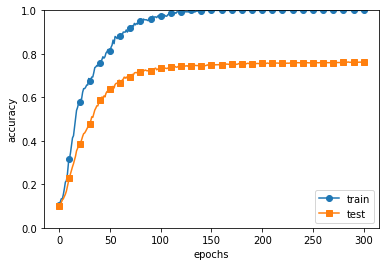

In [6]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
#     def __init__(self, dropout_ratio=0.5):
#         self.dropout_ratio = dropout_ratio
#         self.mask = None

#     def forward(self, x, train_flg=True): 
#         if train_flg:                                                   # x와 형상이 같은 배열을 무작위로 형성하고
#             self.mask = np.random.rand(*x.shape) > self.dropout_ratio   # 그 값이 dropout_ratio보다 큰 원소만 True      
#             return x * self.mask                                        # 삭제할 뉴런은 self.mask에 False로 표시.
#         else:
#             return x * (1.0 - self.dropout_ratio)

#     def backward(self, dout):                                 # 역전파 때 동작은 Relu와 같다.
#         return dout * self.mask
use_dropout = False  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


### 드롭아웃 적용

train loss:2.3275475836748973
=== epoch:1, train acc:0.09, test acc:0.1067 ===
train loss:2.3328689964827927
train loss:2.329014949365837
train loss:2.3330683002738
=== epoch:2, train acc:0.09, test acc:0.1063 ===
train loss:2.326290523658757
train loss:2.320831150617492
train loss:2.3216062473991723
=== epoch:3, train acc:0.09, test acc:0.107 ===
train loss:2.322454164360728
train loss:2.3146547804228677
train loss:2.3098307632678865
=== epoch:4, train acc:0.09, test acc:0.1067 ===
train loss:2.3131347767063097
train loss:2.3030111722600437
train loss:2.3136043004693208
=== epoch:5, train acc:0.09333333333333334, test acc:0.1075 ===
train loss:2.2999478941867646
train loss:2.301217982723068
train loss:2.3193331832202393
=== epoch:6, train acc:0.09333333333333334, test acc:0.1077 ===
train loss:2.312994592221569
train loss:2.2999727571186948
train loss:2.2936257001704976
=== epoch:7, train acc:0.09333333333333334, test acc:0.1083 ===
train loss:2.310178338565941
train loss:2.3093690171

=== epoch:57, train acc:0.34, test acc:0.2768 ===
train loss:2.23614011971402
train loss:2.216837681684678
train loss:2.220611265090806
=== epoch:58, train acc:0.34, test acc:0.2784 ===
train loss:2.2347513373263554
train loss:2.2424239293405335
train loss:2.2265683527936138
=== epoch:59, train acc:0.34, test acc:0.2783 ===
train loss:2.2289199208713173
train loss:2.216056842684943
train loss:2.2475029961334645
=== epoch:60, train acc:0.3466666666666667, test acc:0.2817 ===
train loss:2.2239762853151777
train loss:2.224939885943382
train loss:2.2151964798057175
=== epoch:61, train acc:0.35, test acc:0.2832 ===
train loss:2.2367547762382625
train loss:2.2384961064212017
train loss:2.230210260462224
=== epoch:62, train acc:0.35, test acc:0.2848 ===
train loss:2.2317249562856505
train loss:2.2432354324983894
train loss:2.225312805433584
=== epoch:63, train acc:0.3466666666666667, test acc:0.2884 ===
train loss:2.2319926163317336
train loss:2.2324947147028325
train loss:2.226964817410112
=

=== epoch:113, train acc:0.4066666666666667, test acc:0.3263 ===
train loss:2.121535690812987
train loss:2.1147366642574297
train loss:2.119877972206582
=== epoch:114, train acc:0.4066666666666667, test acc:0.3257 ===
train loss:2.1207589103296782
train loss:2.089370564765281
train loss:2.1136881492824173
=== epoch:115, train acc:0.4033333333333333, test acc:0.3256 ===
train loss:2.0635627810725086
train loss:2.1129448191484466
train loss:2.1477097980928805
=== epoch:116, train acc:0.4066666666666667, test acc:0.3237 ===
train loss:2.1044768076472025
train loss:2.1112585398125088
train loss:2.106590616325111
=== epoch:117, train acc:0.41, test acc:0.3239 ===
train loss:2.1081095371143417
train loss:2.030372127130256
train loss:2.083454629618295
=== epoch:118, train acc:0.41333333333333333, test acc:0.3235 ===
train loss:2.078816963008653
train loss:2.1294559622969924
train loss:2.1029728251043873
=== epoch:119, train acc:0.41333333333333333, test acc:0.3232 ===
train loss:2.09692427382

=== epoch:168, train acc:0.4866666666666667, test acc:0.3724 ===
train loss:1.9100466331152095
train loss:1.8123590962918215
train loss:1.8577844878278669
=== epoch:169, train acc:0.49, test acc:0.3745 ===
train loss:1.850059145518021
train loss:1.7940478169634997
train loss:1.8257063647577285
=== epoch:170, train acc:0.4866666666666667, test acc:0.3748 ===
train loss:1.909063966588605
train loss:1.867016426174508
train loss:1.876476147176387
=== epoch:171, train acc:0.48333333333333334, test acc:0.3763 ===
train loss:1.9364117375791972
train loss:1.834468933710318
train loss:1.8960822763684686
=== epoch:172, train acc:0.49, test acc:0.3792 ===
train loss:1.933523290522972
train loss:1.886485699108511
train loss:1.922513330588431
=== epoch:173, train acc:0.49333333333333335, test acc:0.3821 ===
train loss:1.8411934737572093
train loss:1.8161058494376212
train loss:1.8891920316827104
=== epoch:174, train acc:0.49333333333333335, test acc:0.3831 ===
train loss:1.9607782076159312
train lo

=== epoch:223, train acc:0.5433333333333333, test acc:0.4335 ===
train loss:1.571883826488917
train loss:1.5639335705142399
train loss:1.6620996334511096
=== epoch:224, train acc:0.5533333333333333, test acc:0.4338 ===
train loss:1.6377562408471977
train loss:1.5028871799188455
train loss:1.7084499109768836
=== epoch:225, train acc:0.5533333333333333, test acc:0.4347 ===
train loss:1.5092118761893496
train loss:1.5868710681708527
train loss:1.485690034421639
=== epoch:226, train acc:0.5433333333333333, test acc:0.4341 ===
train loss:1.4744843973551036
train loss:1.642168649674224
train loss:1.5496820506345912
=== epoch:227, train acc:0.5533333333333333, test acc:0.4347 ===
train loss:1.5707906272259173
train loss:1.4962907174605817
train loss:1.5706950432918194
=== epoch:228, train acc:0.5533333333333333, test acc:0.4335 ===
train loss:1.4741649890338941
train loss:1.4798661809059461
train loss:1.4829284614992222
=== epoch:229, train acc:0.5566666666666666, test acc:0.4362 ===
train lo

=== epoch:278, train acc:0.6366666666666667, test acc:0.4958 ===
train loss:1.1638691365197047
train loss:1.2236182285326942
train loss:1.302857179000477
=== epoch:279, train acc:0.6333333333333333, test acc:0.4964 ===
train loss:1.3666986100196257
train loss:1.2229324443420186
train loss:1.147610354184059
=== epoch:280, train acc:0.6366666666666667, test acc:0.4951 ===
train loss:1.3122916377671459
train loss:1.340468161441526
train loss:1.3316168211532275
=== epoch:281, train acc:0.6366666666666667, test acc:0.5004 ===
train loss:1.4082084584093821
train loss:1.104791438498695
train loss:1.332020267716424
=== epoch:282, train acc:0.6433333333333333, test acc:0.5016 ===
train loss:1.1189927104080253
train loss:1.2833700370658523
train loss:1.2419735837833172
=== epoch:283, train acc:0.6433333333333333, test acc:0.4996 ===
train loss:1.1303987343357518
train loss:1.2637233036006075
train loss:1.2429469238672934
=== epoch:284, train acc:0.65, test acc:0.5015 ===
train loss:1.25314182811

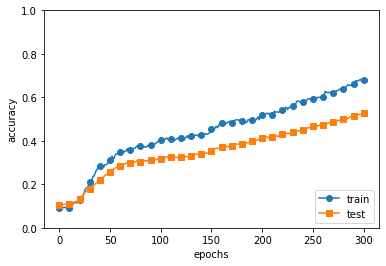

In [7]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
#     def __init__(self, dropout_ratio=0.5):
#         self.dropout_ratio = dropout_ratio
#         self.mask = None

#     def forward(self, x, train_flg=True): 
#         if train_flg:                                                   # x와 형상이 같은 배열을 무작위로 형성하고
#             self.mask = np.random.rand(*x.shape) > self.dropout_ratio   # 그 값이 dropout_ratio보다 큰 원소만 True      
#             return x * self.mask                                        # 삭제할 뉴런은 self.mask에 False로 표시.
#         else:
#             return x * (1.0 - self.dropout_ratio)

#     def backward(self, dout):                                 # 역전파 때 동작은 Relu와 같다.
#         return dout * self.mask
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


훈련데이터와 시험데이터에 대한 정확도 차이가 줄었다   
훈련 데이터의 정확도가 100%에 도달하지도 않게 되었다   
드롭아웃을 쓰면 표현력을 높이면서 오버피팅을 억제할 수 있다

### 드롭아웃은 앙상블 학습과 비슷하다.   
학습시 뉴런을 무작위로 삭제하는 행위는   
매번 다른 모델을 학습시키는 것으로 해석할 수 있기 때문이다   
그리고 추론 시에는    
뉴런의 출력에 삭제한 비율을 곱함으로써 앙상블 학습에서 여러 모델을 평균내는 것과 같은 효과를 얻는다

# 6. 적절한 하이퍼파라미터 값 찾기

**하이퍼 파라미터의 종류**   
각 층의 뉴런수   
배치 크기   
학습률   
가중치 감소

훈련데이터 : 매개변수 학습에만 사용   
검증 데이터 : 하이퍼 파라미터 성능 평가 (하이퍼 파라미터 전용 확인 데이터)   
    시험데이터 : 신경망의 범용 성능 평가 ( 마지막에 한번만 사용 )

하이퍼 파라미터 최적화의 핵심은   
최적값이 존재하는 범위를 조금씩 줄여가는 것이다.   
   
    1. 먼저 대략적인 범위를 설정하고   
    2. 그 안에서 무작위로 하이퍼파라미터 값을 샘플링 한후 (랜덤서치)   
    3. 평가, 재탐색 반복   
   
랜덤서치가 그리드 서치보다 좋은 결과를 내는 이유는 최종 정확도에 미치는 영향력이 하이퍼파라미터마다 다르기 때문이다

대략적인 범위는  10의 거듭제곱 단위로 지정한다. 이를 로그 스케일로 지정한다고 한다.   
예를 들어 0.001 에서 1000 사이   
이를 파이썬 코드로는 10 ** np.random.uniform(-3, 3) 처럼 작성할 수 있다

학습에 걸리는 시간을 작게하여 1회 평가에 걸리는 시간을 단축하는 전략을 쓴다   
훈련 데이터 사이즈를 줄이는 방법

이렇게 하이퍼 파라미터를 최적화하는 방법은 수행자의 지혜와 직관에 의존한다   
더 세련된 방법으로   
베이즈 최적화가 있다.

# 하이퍼파라미터 최적화 구현하기
### 무작위로 추출한 값부터 시작하여 두 하이퍼파라미터(가중치 감소 계수, 학습률)를 최적화해봅니다.

val acc:0.23 | lr:0.001380595898364796, weight decay:2.0723108694306057e-06
val acc:0.18 | lr:0.00013998028246759155, weight decay:1.665495762584484e-07
val acc:0.12 | lr:0.00022525061020612426, weight decay:2.5843958784090977e-06
val acc:0.14 | lr:0.000953643213933891, weight decay:1.5982677327159032e-06
val acc:0.12 | lr:2.722310400212052e-05, weight decay:1.1663937201381329e-05
val acc:0.11 | lr:7.085557597087574e-05, weight decay:1.0578233765008599e-07
val acc:0.16 | lr:0.0007198442959615507, weight decay:2.27653137464911e-06
val acc:0.77 | lr:0.008829633473763886, weight decay:6.679775794621361e-05
val acc:0.16 | lr:0.0004857590965631007, weight decay:1.0606249118359291e-05
val acc:0.12 | lr:3.4764372263252014e-06, weight decay:4.6998085123874475e-07
val acc:0.05 | lr:1.8840823571893535e-06, weight decay:8.246476793887349e-05
val acc:0.19 | lr:2.2042566091963765e-05, weight decay:2.794942452642636e-07
val acc:0.14 | lr:2.1432726118459375e-06, weight decay:2.9074270868440338e-08
va

Best-9(val acc:0.58) | lr:0.003845159991548534, weight decay:2.1655160980814184e-05
Best-10(val acc:0.52) | lr:0.004240423090029219, weight decay:5.358428005554057e-08
Best-11(val acc:0.48) | lr:0.0033116926212162926, weight decay:2.7622394157765697e-08
Best-12(val acc:0.48) | lr:0.004495068131988971, weight decay:1.7107105797024198e-05
Best-13(val acc:0.47) | lr:0.0034158517822081426, weight decay:8.033973140509711e-05
Best-14(val acc:0.46) | lr:0.004522916877400226, weight decay:3.442646581898697e-08
Best-15(val acc:0.45) | lr:0.0038410868542265897, weight decay:1.520016256847304e-07
Best-16(val acc:0.44) | lr:0.002739370095605463, weight decay:9.181744082229651e-06
Best-17(val acc:0.33) | lr:0.0017862584331552747, weight decay:2.7222116533354803e-06
Best-18(val acc:0.28) | lr:0.0013929327669364208, weight decay:7.923724122247379e-06
Best-19(val acc:0.27) | lr:0.0023858826734277044, weight decay:6.870740385735787e-05
Best-20(val acc:0.24) | lr:0.0009122201013312923, weight decay:8.04

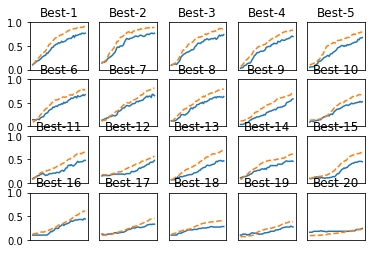

In [11]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)   # 람다값의 범위 
    lr = 10 ** np.random.uniform(-6, -2)            # 학습률의 범위 
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()


검증 데이터의 정확도가 높은 순서로 나열    
best-5 출력   

In [ ]:
Best-1(val acc:0.77) | lr:0.008829633473763886, weight decay:6.679775794621361e-05
Best-2(val acc:0.77) | lr:0.007799159621555063, weight decay:3.4399392600695647e-06
Best-3(val acc:0.74) | lr:0.008289431952260248, weight decay:2.7711379130616444e-05
Best-4(val acc:0.7) | lr:0.006542905311492265, weight decay:4.720835034158211e-06
Best-5(val acc:0.68) | lr:0.00658969581311878, weight decay:6.747673849527349e-06

이를 통해     
학습률은 처음 지정한 대략적인 범위 0.000001 에서 0.01 를   
0.001 에서 0.01 로 좁혀볼 수 있다   
   
       
        
람다값은 처음 지정한 대략적인 범위 0.00000001 에서 0.0001 를   
0.0000001 에서 0.000001 로 좁혀볼 수 있다    
     
       
        좁힌 범위에서 다시 재탐색 반복